# Black Scholes valuation methods

[*Black Scholes model WIKI*](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model). 

More resources on Nicolas Cantarutti:
https://github.com/MichaMucha/Financial-Models-Numerical-Methods

The purpose of this notebook is to review the most common algorithms and implement them numerically. 

## Contents
   - [European option](#sec1)
      - [Put-Call parity](#sec1.1)
   - [Numerical integration](#sec2)
   - [Monte Carlo method](#sec3)
   - [Binomial tree](#sec4)
   - [Limits of the model](#sec5)

In [1]:
import numpy as np
import scipy as scp
import scipy.stats as ss
from scipy.integrate import quad
from functools import partial
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

<a id='sec1'></a>
## European option

Under the Black-Scholes (BS) model, the best method to price a vanilla European option is to use the [BS closed formula](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model).

The **BS formula** for a call is:

$$ C(t,T,S_t,K,r,\sigma) = S_t N(d_1) - K e^{-r(T-t)} N(d_2) $$

with 

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} \biggl[ \log \biggl( \frac{S_t}{K} \biggr) + \biggl(r + \frac{\sigma^2}{2} \biggr) (T-t) \biggr] \quad \mbox{and} \quad d_2 = d_1 - \sigma \sqrt{T-t} $$

where $N$ is the cumulative distribution function of a standard normal random variable.    
The formula for a put is similar and can be found in the wiki page.

The value of an option can be also computed as the discounted expectation of a future payoff in this way:

$$\begin{aligned}
 C(S_t,K,T) &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_t \biggr] \\
            &= e^{-r(T-t)} \int_0^{\infty} (S_T - K)^+ f(S_T|S_t) dS_T   \quad \text{(see comment below)} \\
            &= e^{-r(T-t)} \int_K^{\infty} (S_T - K) f(S_T|S_t) dS_T 
\end{aligned}$$

where $f(S_T|S_t)$ is the risk neutral transition probability of the process $\{S_u\}_{u\in [t,T]}$. This is a log-normal density function 

$$ f(S_T|S_t) = \frac{1}{S_T \sigma \sqrt{2\pi (T-t)}} \; e^{- \frac{ \biggl[\log(S_T) - \bigl(\log(S_t) + (r-\frac{1}{2} \sigma^2)(T-t) \bigr) \biggr]^2}{2\sigma^2 (T-t)}} $$


#### Comment:
In this context there is a clear abuse of notation!! Usually in statistics random variables are indicated by capital letters, and non-random variables are indicated with small letters. However, it is very common to indicate the stock price in the Black-Scholes formula with a capital letter. Here I used this notation in order to be consistent with the [wiki notation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#Notation), although I think this choice can generate misunderstandings. To summarize:    
In the function $C(S_t,K,T)$ the variables are non-random! Inside the expectation $\mathbb{E}^{\mathbb{Q}}\bigl[ (S_T - K)^+ \big| S_t \bigr]$, the variable $S_T$ is random. In the second and third lines, $S_T$ is not random and consequently the integral in $dS_T$ **is NOT** a stochastic integral. 

### Let us analyze better the previous formulas

\begin{align*}
 C(S_t,K,T) &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_t \biggr] \\
            &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] 
              - e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ K \mathbb{1}_{S_T >K} \bigg| S_t \biggr] \\
            &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] 
              - e^{-r(T-t)} K \, \underbrace{\mathbb{Q}\biggl[ S_T >K \bigg| S_t \biggr]}_{N(d_2)} \\            
\end{align*}

Let us introduce the following change of measure (under the stock numeraire):

$$ \begin{aligned}
\frac{d \tilde{\mathbb{Q}} }{ d \mathbb{Q} } &= \frac{S_T}{\mathbb{E}^\mathbb{Q}[S_T]} = \frac{S_T}{S_t e^{r(T-t)}}  \\ 
                                            &= \frac{S_t e^{(r -\frac{1}{2}\sigma^2)(T-t) + \sigma W_{T-t}} }{S_t e^{r(T-t)}} \\
                                            &=   e^{ -\frac{1}{2}\sigma^2(T-t) + \sigma W_{T-t} } \quad \text{(exponential martingale)} 
\end{aligned} $$

By [Girsanov theorem](https://en.wikipedia.org/wiki/Girsanov_theorem), under $\tilde{\mathbb{Q}}$ the driving Brownian motion has the new dynamics 

$$ \tilde{W_t} = W_t - \sigma t $$

and the corresponding stock dynamics becomes

$$\begin{aligned}
 \frac{dS_t}{S_t} &= r dt + \sigma dW_t \\
                  &= (r+\sigma^2) dt + \sigma d\tilde{W}_t 
\end{aligned}$$

The first term is

$$ \begin{aligned}
 e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] =& e^{-r(T-t)} \mathbb{E}^{\tilde{\mathbb{Q}}} 
                 \biggl[ \frac{d \mathbb{Q} }{ d \tilde{\mathbb{Q}}}  S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] \\
                     =& e^{-r(T-t)} \mathbb{E}^{\tilde{\mathbb{Q}}} 
                 \biggl[ \frac{e^{r(T-t)}S_t}{S_T}  S_T \mathbb{1}_{S_T >K} \bigg| S_t \biggr] \\ 
                    =& S_t \, \underbrace{\tilde{\mathbb{Q}} ( S_T > K | S_t)}_{N(d_1)}
\end{aligned}$$

We have just seen how to interpret the terms $N(d_1)$ and $N(d_2)$. These are the risk neutral probabilities of $S_T > K$ in the stock and money market numeraires respectively.

Let us consider the following set of parameters, that will be recurrent in all the next notebooks. 

In [12]:
S0=100.0    # spot stock price
K=100.0     # strike
T=1.0       # maturity 
r=0       # risk free rate 
sig=0.2     # diffusion coefficient or volatility

<a id='sec1.1'></a>
### Put-Call parity

This is an important formula [wiki page](https://en.wikipedia.org/wiki/Put%E2%80%93call_parity)

$$ Call - Put = S_0 - K e^{-rT}  $$

Let us check if it works:

In [13]:
def BlackScholes(S,K,r,T,sigma, voltype='Normal', option = 'call'):
    """Return price of swaption in BlackScholes model
    
    Inputs:
    S = spot (current value of forward swap rate)
    K = strike
    sigma = volatility (in normal or lognormal units)
    T = expiry
    r = interest rates
    voltype = one of 'Normal' or 'Lognormal' """
    if voltype=='Normal':
        moneyness = S-K
        atMaturityStdev = sigma*np.sqrt(T)
        scaledMoneyness = moneyness/atMaturityStdev
        return (moneyness * norm.cdf(scaledMoneyness)+atMaturityStdev * norm.pdf(scaledMoneyness))
    elif voltype=='Lognormal':
        d1 = (np.log(1.0*S/K)+(r+sigma**2/2.0)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        if  option == 'call':
            return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2) 
        else:
            return (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    else:
        raise Exception("Unsupported option volatility type, should be 'Normal' or 'Lognormal', '" + voltype + "' entered."  )
        
print("BS Formula Price: ", BlackScholes(S0,K,r,T, sig, voltype='Lognormal'))

call = BlackScholes(S0,K,r,T, sig, voltype='Lognormal')
put = BlackScholes(S0,K,r,T, sig, 'Lognormal' , "put")
print('call:',call) 
print('pul:',put) 

print('call-put', call - put , 'S0 - K * np.exp(-r*T):', S0 - K * np.exp(-r*T) )

BS Formula Price:  7.965567455405804
call: 7.965567455405804
pul: 7.965567455405804
call-put 0.0 S0 - K * np.exp(-r*T): 0.0


In [14]:
from scipy.optimize import newton
def impliedVol(Opt_price, S0,K,r,T, vol_guess = sig, voltype = 'Lognormal'):
    return newton(func = lambda sigma:BlackScholes(S0,K,r,T, sigma, voltype='Lognormal')-Opt_price,
                  x0 = vol_guess,
                  tol = 1e-8)
price = BlackScholes(S0,K,r,T, sig, voltype='Lognormal')
print ("impliedVol" , impliedVol(price, S0,K,r,T, vol_guess = 0.11, voltype = 'Lognormal'))

impliedVol 0.20000000000000004


<a id='sec2'></a>
## Numerical integration

I want to play a bit with the different formulas written above.  

Let us compute the option prices by integrating the log-normal density:

In [15]:
e_ret = np.log(S0) + ( r - 0.5 * sig**2 ) * T   # expected return of the log-price
vol = sig * np.sqrt(T)                          # standard deviation of the log-price

# log-normal density (defined above) 
def log_normal(x, e_ret, vol):
    return 1/(x*vol*np.sqrt(2*np.pi)) * np.exp(- (np.log(x) - e_ret)**2 /(2*vol**2) )

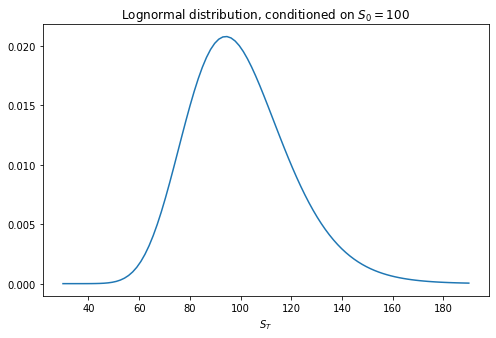

In [16]:
plt.figure(figsize=(8,5))
x = np.linspace(30,190, 100)
plt.plot(x, log_normal(x, e_ret,vol))
plt.title("Lognormal distribution, conditioned on $S_0=100$")
plt.xlabel("$S_T$"); plt.show()

The function `log_normal(x, e_ret, vol)` defined above, corresponds to the scipy.stats function: 
```
ss.lognorm.pdf(x, vol, scale=np.exp(e_ret) ).
```

In the next calculation, I'm going to use the scipy function.    
Let us perform the integration with the `scipy.integrate` function [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html):

In [17]:
def integrand_LN(S, strike, e_ret, vol, payoff):
    if payoff == "call":
        return (S - strike ) * ss.lognorm.pdf(S, vol, scale=np.exp(e_ret))
    elif payoff == "put":
        return (strike - S) * ss.lognorm.pdf(S, vol, scale=np.exp(e_ret))

call = quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, "call") )[0]  * np.exp(-r*T)
put = quad(integrand_LN, 0, K, args=(K, e_ret, vol, "put") )[0]  * np.exp(-r*T)

print("Call price: {} \nPut price: {} ".format(call,put) )

Call price: 7.965567455405843 
Put price: 7.965567455405761 


The put option payoff $(K-S_T)^+$ is positive for $S_T < K$.    
- In the call case, the integration is from $K$ to $\infty$.
- In the put case, the integration is from $0$ to $K$.

What if we use the change of measure proposed above?  In this way the integrations are simpler.    
Let us compute $\tilde{\mathbb{Q}}( S_T > K )$ and $\mathbb{Q}( S_T > K )$.

In [18]:
e_ret_1 = np.log(S0) + ( r + 0.5 * sig**2 ) * T  # expected return of the log-price under the new measure

Q1 = quad(lambda S: ss.lognorm.pdf(S, vol, scale=np.exp(e_ret_1)), K, np.inf )[0]
print("Risk neutral probability under stock numeraire,\n Q1 =", Q1)
Q2 = quad(lambda S: ss.lognorm.pdf(S, vol, scale=np.exp(e_ret)), K, np.inf )[0]
print("Risk neutral probability under money market numeraire,\n Q2 =", Q2)

print("BS call price: ", S0 * Q1 - K* np.exp(-r*T) *Q2  )

Risk neutral probability under stock numeraire,
 Q1 = 0.5398278372770288
Risk neutral probability under money market numeraire,
 Q2 = 0.4601721627229738
BS call price:  7.965567455405498


It is quite common to compute the Black-Scholes formula using $N(d_1)$ and $N(d_2)$.   
The reason is that the cumulative function of the standard Normal distribution is more accessible (I guess). In the `BS_pricer` class I used the function `scipy.stats.norm.cdf`.     

For completeness, let me recall that if $X_T$ is a Normal random variable, then $S_T = S_0 e^{X_T}$ is Log-Normal. Therefore we have:

$$ \mathbb{Q}( S_T > K ) = \mathbb{Q}\biggl( S_0 e^{X_T} > K \biggr) = \mathbb{Q}\biggl( X_T > \log \frac{K}{S_0} \biggr). $$

This permits to use the Normal cumulative function.

<a id='sec3'></a>
## Monte Carlo method

I'm going to simulate the random variables: 

$$ S_T^i = S_0 e^{(r -\frac{1}{2}\sigma^2)T + \sigma W_{T}^i} $$

for $1 \leq i \leq N$.    
Then use the approximation for a call option:

$$ \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_0 \biggr] \; 
\approx \; \frac{1}{N} \sum_{i=1}^N (S_T^i - K)^+
$$

For a put option I use this payoff $(K - S_T )^+$ inside the expectation.

In [19]:
np.random.seed(seed=44)  # seed for random number generation
N = 10000000  # Number of random variables

W = ss.norm.rvs( (r-0.5*sig**2)*T , np.sqrt(T)*sig, N)
S_T = S0 * np.exp(W)

call = scp.mean( np.exp(-r*T) * np.maximum(S_T-K,0) )
put = scp.mean( np.exp(-r*T) * np.maximum(K-S_T,0) )
call_err = ss.sem( np.exp(-r*T) * np.maximum(S_T-K,0) )  # standard error
put_err = ss.sem( np.exp(-r*T) * np.maximum(K-S_T,0) )   # standard error

def BSMC(S0, K, r, T, sig , N , payoff):
    np.random.seed(seed=3) 
    W = ss.norm.rvs( loc=(r - 0.5 * sig**2)*T, scale=np.sqrt(T)*sig, size=N )
    S_T = S0 * np.exp(W)
    if payoff =="call":
        V = np.average(np.maximum(S_T-K, 0.0)*np.exp(-r*T))
    else:
        V = np.average(np.maximum(K-S_T, 0.0)*np.exp(-r*T))
    return V

C:\Users\Tianyi Zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  import sys
C:\Users\Tianyi Zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  


In [116]:
T = 10
r_10 = 1-ss.norm.cdf(0.05,loc = 0.03, scale = np.sqrt(0.0005*(1-np.exp(-2))))
def MCR(N):
    np.random.seed(3)
    W = ss.norm.rvs(loc = 0.03, scale = np.sqrt(0.0005*(1-np.exp(-2))), size=N)
    higher = 0
    for x in W:
        if x>0.05:
            higher+=1
    return higher/len(W)
    
def MCR2(dt,N):
    np.random.seed(2)
    Ws = ss.norm.rvs(loc = 0.03, scale = np.sqrt(0.0005*(1-np.exp(-0.2*2))), size=N)
    dr
    return Ws,Wt

In [117]:
MCR2(2,50)

(array([ 0.02464925,  0.02927759,  0.00257337,  0.05105944,  0.00697408,
         0.0191928 ,  0.0364565 ,  0.01401174,  0.01641695,  0.01832925,
         0.03708012,  0.05942966,  0.03053332,  0.01564695,  0.03692097,
         0.0223459 ,  0.02975438,  0.04508584,  0.02039808,  0.03011588,
         0.01872597,  0.02799154,  0.03329411,  0.01730506,  0.02564986,
         0.02696763,  0.02181315,  0.01475224,  0.01175299,  0.02802927,
         0.02654558,  0.05864852, -0.00125999,  0.0314473 ,  0.03475614,
         0.04745634,  0.03644335,  0.01916114,  0.03000013,  0.03696327,
         0.02597487,  0.03989902,  0.00601558,  0.05222668,  0.04884352,
         0.02569024,  0.03784901,  0.03061589,  0.01935473,  0.03112611]),
 [array([0.03417295]),
  array([0.0256495]),
  array([-0.00100308]),
  array([0.05035046]),
  array([0.01110106]),
  array([0.03136326]),
  array([0.03041421]),
  array([0.01885179]),
  array([0.01847442]),
  array([0.00063485]),
  array([0.03308813]),
  array([0.0581

In [111]:
# discN = np.array([10,50,100,200,1000,5000,10000,20000,30000,50000,100000])
MC_Rs = MCR2(2,500)[0]
MC_Rt = MCR2(2,500)[1]
covv = np.cov(MC_Rs,MC_Rt)
covv
np.corrcoef(MC_Rs,MC_Rt)

array([[1., 1.],
       [1., 1.]])

In [90]:
covv[0][1]/(np.sqrt(covv[0][0])*np.sqrt(covv[1][1]))

-0.08243531009608715

In [80]:
np.sqrt(0.00016405)*np.sqrt(2.09712539e-04)

0.0001854813791811728

(0.14, 0.18)

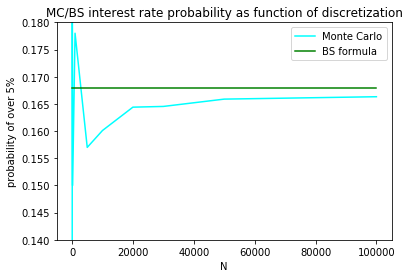

In [43]:
discN = np.array([10,50,100,200,1000,5000,10000,20000,30000,50000,100000])
MC_R =[MCR(x) for x in discN]
line_MC = plt.plot(discN, MC_R, color='cyan',label='Monte Carlo')
line_BS = plt.plot(discN, 0.168 +np.zeros(discN.size), color='green',label="BS formula")
plt.xlabel("N"); plt.ylabel("probability of over 5%"); plt.title("MC/BS interest rate probability as function of discretization")
plt.legend()
plt.ylim(0.14,0.18)

In [28]:
print("Call price: {}, with error: {}".format(call, call_err))
print("Put price: {}, with error: {}".format(put, put_err))
# print("Call price:",BSMC(S0,K,r,T, sig,30000,"call"))

(BSMC(100,100,0,T, 0.15,30000,"call")-BSMC(100,120,0,T, 0.15,30000,"call"))/20

Call price: 7.961852688922241, with error: 0.004158760654643069
Put price: 7.970162279324616, with error: 0.003289727041261106


0.2507919198876931

### Black Scholes pricer
But now let's have a look at the prices obtained by different pricing methods:

<a id='sec4'></a>
## Binomial tree


Of course I cannot forget about the Binomial model!
This is a simple but very powerful numerical method!

I expect you to be familiar with this model. If not, have a look at the [wiki page](https://en.wikipedia.org/wiki/Binomial_options_pricing_model). 
Although I said I expect you to know the model, I'm not expecting that you have already implemented it!     
Therefore, here I present an efficient implementation:

In [21]:
N = 100              # number of periods or number of time steps  
payoff = "call"        # payoff 

dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

V = np.zeros(N+1)                             # initialize the price vector
S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

a = np.exp(r * dT)    # risk free compounded return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability   

if payoff =="call":
    V[:] = np.maximum(S_T-K, 0.0)
else:
    V[:] = np.maximum(K-S_T, 0.0)

for i in range(N-1, -1, -1):
    V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
        
print("BS Tree Price: ", V[0])

BS Tree Price:  7.9456788716384725


BS Tree Price:  7.9456788716384725
BS Formula Price:  7.965567455405804


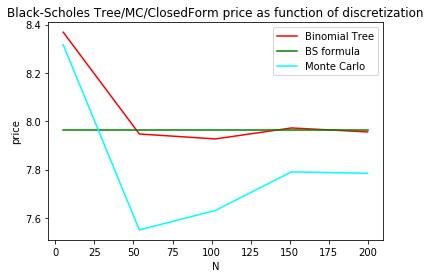

In [22]:
def tree_call(S0, K, r, T, sig , N , payoff):

    dT = float(T) / N                             # Delta t
    u = np.exp(sig * np.sqrt(dT))                 # up factor
    d = 1.0 / u                                   # down factor 
    N=int(N)
    V = np.zeros(N+1)                             # initialize the price vector
    S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

    a = np.exp(r * dT)    # risk free compounded return
    p = (a - d)/ (u - d)  # risk neutral up probability
    q = 1.0 - p           # risk neutral down probability   

    if payoff =="call":
        V[:] = np.maximum(S_T-K, 0.0)
    else:
        V[:] = np.maximum(K-S_T, 0.0)

    for i in range(N-1, -1, -1):
        V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
    return V[0]
N =100

print("BS Tree Price: ", tree_call(S0, K, r, T, sig , N , "call"))
print("BS Formula Price: ", BlackScholes(S0,K,r,T, sig, voltype='Lognormal'))

discN = np.linspace(5, 200, 5)
prices = [tree_call(S0, K, r, T, sig , x , "call") for x in discN]
line_tree = plt.plot(discN,prices, color='red', label ="Binomial Tree")
plt.xlabel("N"); plt.ylabel("price"); plt.title("Black-Scholes Tree/MC/ClosedForm price as function of discretization")

line_BS = plt.plot(discN, BlackScholes(S0,K,r,T,sig, voltype='Lognormal') +np.zeros(discN.size), color='green',label="BS formula")
#plt.plot(discN, quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, "call") )[0]  * np.exp(-r*T) +np.zeros(discN.size), color='green',label="BS formula")

MCPrice =[BSMC(S0,K,r,T, sig,int(x)*100,"call") for x in discN]
line_MC = plt.plot(discN, MCPrice, color='cyan',label='Monte Carlo')
plt.legend()
#plt.show()

plt.savefig('BinormialvsMonteCarlo.png')


In [23]:
np.random.seed(seed=42) 

r = 0
sig = 0.2
T = 1
N = 20000 
S0 = 100
K=100

W = ss.norm.rvs( loc=(r - 0.5 * sig**2)*T, scale=np.sqrt(T)*sig, size=N )
S_T = S0 * np.exp(W)
V = np.average(np.maximum(S_T-K, 0.0)*np.exp(-r*T))
print (V)
print ('bias', np.average(W) , (r - 0.5 * sig**2)*T)
print ('vol', np.std(W) , np.sqrt(T)*sig)
print ('stock Value at T', np.average(S_T*np.exp(-r*T)))

#compute the bias
bias = S0 - np.average(S_T*np.exp(-r*T))
volBias = np.sqrt(T)*sig/np.std(W)
NewSt = (S_T +bias)
print ('New stock Value at T', np.average(NewSt*np.exp(-r*T)))

#let's do antithetic

8.035558000586477
bias -0.018860193030353904 -0.020000000000000004
vol 0.20044351583482092 0.2
stock Value at T 100.12285790262038
New stock Value at T 100.00000000000001


<a id='sec5'></a>
## Moment matching : Does it help Monte Carlo?

BS MC Price:  7.813315805123645
BS MC Anti+Match Price:  7.969752450897273
BS Tree Price:  7.965467887105893
BS Formula Price:  7.965567455405804


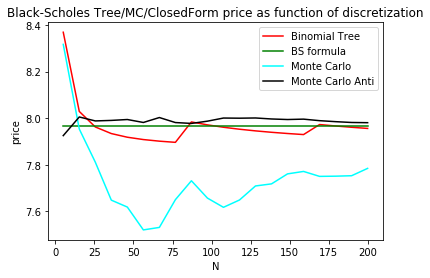

In [24]:
def BSMCAnti(S0, K, r, T, sig , N , payoff):
    np.random.seed(seed=3) 
    W = ss.norm.rvs( loc=0, scale=np.sqrt(T)*sig, size=int(N/2) )
    volBias = np.sqrt(T)*sig/np.std(W)
    S_T = np.concatenate([S0 * np.exp((r - 0.5 * sig**2)*T+W*volBias),S0 * np.exp((r - 0.5 * sig**2)*T-W*volBias)])
    
    if payoff =="call":
        V = np.average(np.maximum(S_T-K, 0.0)*np.exp(-r*T))
    else:
        V = np.average(np.maximum(K-S_T, 0.0)*np.exp(-r*T))
    return V

print("BS MC Price: ", BSMC(S0,K,r,T, sig,30000,"call"))
print("BS MC Anti+Match Price: ", BSMCAnti(S0,K,r,T, sig,30000,"call"))

print("BS Tree Price: ", tree_call(S0, K, r, T, sig , N , "call"))
print("BS Formula Price: ", BlackScholes(S0,K,r,T, sig, voltype='Lognormal'))

discN = np.linspace(5, 200, 20)
prices = [tree_call(S0, K, r, T, sig , x , "call") for x in discN]
line_tree = plt.plot(discN,prices, color='red', label ="Binomial Tree")
plt.xlabel("N"); plt.ylabel("price"); plt.title("Black-Scholes Tree/MC/ClosedForm price as function of discretization")

line_BS = plt.plot(discN, BlackScholes(S0,K,r,T, sig, voltype='Lognormal')+np.zeros(discN.size), color='green',label="BS formula")
#plt.plot(discN, quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, "call") )[0]  * np.exp(-r*T) +np.zeros(discN.size), color='green',label="BS formula")

MCPrice =[BSMC(S0,K,r,T, sig,int(x)*100,"call") for x in discN]
line_MC = plt.plot(discN, MCPrice, color='cyan',label='Monte Carlo')


MCPrice2 =[BSMCAnti(S0,K,r,T, sig,int(x)*100,"call") for x in discN]
line_MC = plt.plot(discN, MCPrice2, color='black',label='Monte Carlo Anti')
plt.legend()


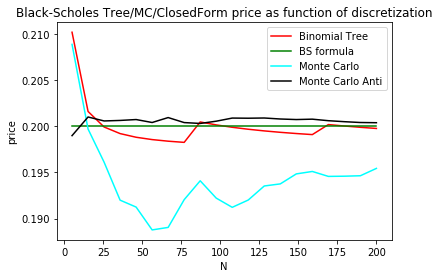

In [25]:

discN = np.linspace(5, 200, 20)
prices = [tree_call(S0, K, r, T, sig , x , "call") for x in discN]
ImpVols = [impliedVol(x, S0,K,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x in prices]
line_tree = plt.plot(discN,ImpVols, color='red', label ="Binomial Tree")
plt.xlabel("N"); plt.ylabel("price"); plt.title("Black-Scholes Tree/MC/ClosedForm price as function of discretization")

line_BS = plt.plot(discN, sig+np.zeros(discN.size), color='green',label="BS formula")
#plt.plot(discN, quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, "call") )[0]  * np.exp(-r*T) +np.zeros(discN.size), color='green',label="BS formula")

MCPrice =[BSMC(S0,K,r,T, sig,int(x)*100,"call") for x in discN]
ImpVolsMC = [impliedVol(x, S0,K,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x in MCPrice]

line_MC = plt.plot(discN, ImpVolsMC, color='cyan',label='Monte Carlo')


MCPrice2 =[BSMCAnti(S0,K,r,T, sig,int(x)*100,"call") for x in discN]
ImpVolsMC2 = [impliedVol(x, S0,K,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x in MCPrice2]

line_MC = plt.plot(discN, ImpVolsMC2, color='black',label='Monte Carlo Anti')
plt.legend()


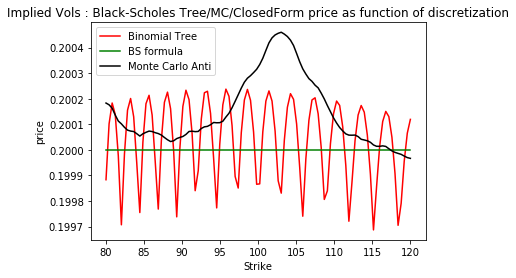

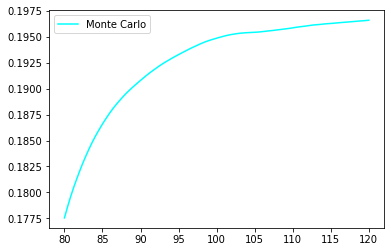

In [102]:
points = 200
Strikes = S0-sig*S0*np.sqrt(T)+np.linspace(0, 1, 100)*sig*S0*np.sqrt(T)*2
prices = [tree_call(S0, x, r, T, sig , points , "call") for x in Strikes]
ImpVols = [impliedVol(x, S0,k,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x,k in zip(prices,Strikes) ]
line_tree = plt.plot(Strikes,ImpVols, color='red', label ="Binomial Tree")
plt.xlabel("Strike"); plt.ylabel("price"); plt.title("Implied Vols : Black-Scholes Tree/MC/ClosedForm price as function of discretization")

line_BS = plt.plot(Strikes, sig+np.zeros(Strikes.size), color='green',label="BS formula")
#plt.plot(discN, quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, "call") )[0]  * np.exp(-r*T) +np.zeros(discN.size), color='green',label="BS formula")

MCPrice =[BSMC(S0,x,r,T, sig,int(points)*100,"call") for x in Strikes]
ImpVolsMC = [impliedVol(x, S0,k,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x,k in zip(MCPrice,Strikes)]

#line_MC = plt.plot(Strikes, ImpVolsMC, color='cyan',label='Monte Carlo')


MCPrice2 =[BSMCAnti(S0,k,r,T, sig,int(points)*100,"call") for k in Strikes]
ImpVolsMC2 = [impliedVol(x, S0,k,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x,k in zip(MCPrice2,Strikes)]

line_MC = plt.plot(Strikes, ImpVolsMC2, color='black',label='Monte Carlo Anti')
plt.legend()

plt.figure(2)
line_MC = plt.plot(Strikes, ImpVolsMC, color='cyan',label='Monte Carlo')
plt.legend()



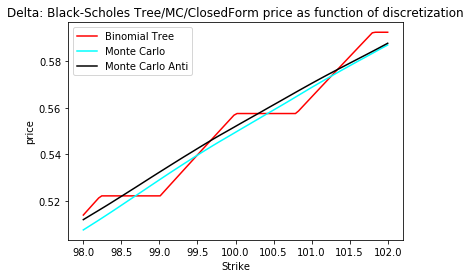

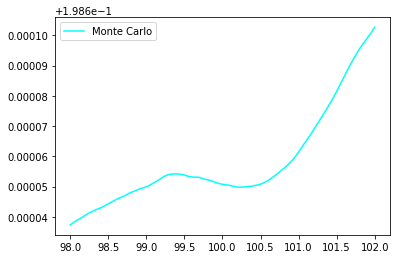

In [27]:
points = 500
K = 100
Strikes = S0-sig*S0*np.sqrt(T)/10.+np.linspace(0, 1, 100)*sig*S0*np.sqrt(T)*2/10.
prices = [tree_call(x, K, r, T, sig , points , "call") for x in Strikes]


delta = [(tree_call(x, K, r, T, sig , points , "call") - tree_call(x*1.01, K, r, T, sig , points , "call"))/(-.01*x)  for x in Strikes ]
line_tree = plt.plot(Strikes, delta, color='red', label ="Binomial Tree")
plt.xlabel("Strike"); plt.ylabel("price"); plt.title("Delta: Black-Scholes Tree/MC/ClosedForm price as function of discretization")

#line_BS = plt.plot(Strikes, sig+np.zeros(Strikes.size), color='green',label="BS formula")
#plt.plot(discN, quad(integrand_LN, K, np.inf, args=(K, e_ret, vol, "call") )[0]  * np.exp(-r*T) +np.zeros(discN.size), color='green',label="BS formula")

MCPrice =[BSMC(S0,x,r,T, sig,int(points)*100,"call") for x in Strikes]
deltaMC = [(BSMC(x,K,r,T, sig,int(points)*100,"call") - BSMC(x*1.01,K,r,T, sig,int(points)*100,"call"))/(-.01*x)  for x in Strikes ]

ImpVolsMC = [impliedVol(x, S0,k,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x,k in zip(MCPrice,Strikes)]

line_MC = plt.plot(Strikes, deltaMC, color='cyan',label='Monte Carlo')


MCPrice2 =[BSMCAnti(S0,k,r,T, sig,int(points)*100,"call") for k in Strikes]
deltaMC2 = [(BSMCAnti(x,K,r,T, sig,int(points)*100,"call") - BSMCAnti(x*1.01,K,r,T, sig,int(points)*100,"call"))/(-.01*x)  for x in Strikes ]

ImpVolsMC2 = [impliedVol(x, S0,k,r,T, vol_guess = 0.11, voltype = 'Lognormal') for x,k in zip(MCPrice2,Strikes)]

line_MC = plt.plot(Strikes, deltaMC2, color='black',label='Monte Carlo Anti')
plt.legend()

plt.figure(2)
line_MC = plt.plot(Strikes, ImpVolsMC, color='cyan',label='Monte Carlo')
plt.legend()

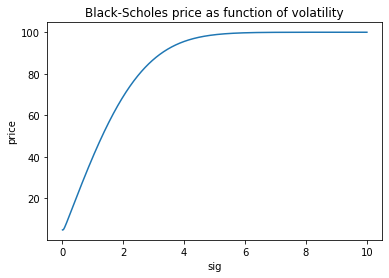

In [21]:
sigmas = np.linspace(0.01, 10, 1000)

plt.plot(sigmas, BlackScholes(S0,K,r,T, sigmas, voltype='Lognormal'))
plt.xlabel("sig"); plt.ylabel("price"); plt.title("Black-Scholes price as function of volatility")
plt.show()

The BS formula is an increasing function of the volatility.    
However, for higher volatilities, the graph becomes almost flat!!

We can conclude that the model is reliable for volatilities in the range $0 - 400\%$.
